# Time Series Data Analytics and Prediction
Used data is collected from one weather station at West Palm Beach airport. Data is daily level since Jan 1 2000.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.parser import parse
from matplotlib import rcParams
import matplotlib.pylab as plb

from sklearn.metrics import mean_squared_error 
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

rcParams['figure.figsize'] = 16, 9

In [2]:
#Read the csv data
df = pd.read_csv('PB_Climate_Data.csv')
df.head()

STATION                                          NAME      DATE   AWND  \
0  USW00012844  WEST PALM BEACH INTERNATIONAL AIRPORT, FL US  1/1/2000   6.49   
1  USW00012844  WEST PALM BEACH INTERNATIONAL AIRPORT, FL US  1/2/2000   6.49   
2  USW00012844  WEST PALM BEACH INTERNATIONAL AIRPORT, FL US  1/3/2000  10.51   
3  USW00012844  WEST PALM BEACH INTERNATIONAL AIRPORT, FL US  1/4/2000   8.50   
4  USW00012844  WEST PALM BEACH INTERNATIONAL AIRPORT, FL US  1/5/2000   9.40   

     FMTM    PGTM  PRCP  SNOW  SNWD  TAVG  ...  WT09  WT10  WT11  WT13  WT14  \
0  1300.0  1601.0   0.0   0.0   0.0  68.0  ...   NaN   NaN   NaN   1.0   NaN   
1  1205.0  1307.0   0.0   0.0   0.0  69.0  ...   NaN   NaN   NaN   NaN   NaN   
2  1055.0  1115.0   0.0   0.0   0.0  74.0  ...   NaN   NaN   NaN   NaN   NaN   
3  1425.0  1454.0   0.0   0.0   0.0  76.0  ...   NaN   NaN   NaN   NaN   NaN   
4  1532.0  1509.0   0.0   0.0   0.0  69.0  ...   NaN   NaN   NaN   NaN   NaN   

   WT16  WT18  WT21  WV03  WV20  
0   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN  
2   1.0   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN  
4   1.0   NaN   NaN   NaN   NaN  

[5 rows x 34 columns]

In [3]:
df.shape

(8064, 34)

In [4]:
df.isnull().sum()

STATION       0
NAME          0
DATE          0
AWND          2
FMTM       3716
PGTM       3865
PRCP          2
SNOW       7612
SNWD       7682
TAVG       2806
TMAX          1
TMIN          1
TSUN       6904
WDF2          1
WDF5         37
WESD       4046
WSF2          1
WSF5         37
WT01       5696
WT02       7931
WT03       6214
WT05       7696
WT07       8045
WT08       7550
WT09       8056
WT10       8047
WT11       8045
WT13       6743
WT14       8048
WT16       5676
WT18       8063
WT21       8062
WV03       8061
WV20       8062
dtype: int64

In [5]:
#Drop columns with all NaN values
df = df.dropna(axis='columns', how ='all')
df.isnull().sum().sum()

156708

In [6]:
#Pick all the columns with less than 100 NaN samples
df = df.loc[:, (df.isna().sum() <100)]
df.head()

STATION                                          NAME      DATE   AWND  \
0  USW00012844  WEST PALM BEACH INTERNATIONAL AIRPORT, FL US  1/1/2000   6.49   
1  USW00012844  WEST PALM BEACH INTERNATIONAL AIRPORT, FL US  1/2/2000   6.49   
2  USW00012844  WEST PALM BEACH INTERNATIONAL AIRPORT, FL US  1/3/2000  10.51   
3  USW00012844  WEST PALM BEACH INTERNATIONAL AIRPORT, FL US  1/4/2000   8.50   
4  USW00012844  WEST PALM BEACH INTERNATIONAL AIRPORT, FL US  1/5/2000   9.40   

   PRCP  TMAX  TMIN   WDF2   WDF5  WSF2  WSF5  
0   0.0  78.0  58.0   80.0   90.0  15.0  17.0  
1   0.0  78.0  59.0   90.0   90.0  15.0  17.0  
2   0.0  79.0  69.0  110.0  100.0  17.0  21.0  
3   0.0  81.0  70.0  140.0  140.0  17.9  21.0  
4   0.0  74.0  64.0   10.0   20.0  17.9  23.0

In [7]:
#Check annual sample count, 2022 only samples from first month.
df['DATE'] = pd.to_datetime(df['DATE'])
df['DATE'].dt.year.value_counts()

2000    366
2020    366
2004    366
2008    366
2016    366
2012    366
2013    365
2021    365
2019    365
2018    365
2017    365
2015    365
2014    365
2011    365
2001    365
2010    365
2009    365
2007    365
2006    365
2005    365
2003    365
2002    365
2022     28
Name: DATE, dtype: int64

In [8]:
#Set date column as index
df = df.set_index('DATE')

In [9]:
#Forward fill any NaN values
df.ffill(inplace=True)
df.isnull().sum().sum()

0

In [10]:
#Check data for any abnormal values
df.describe()

AWND         PRCP         TMAX         TMIN         WDF2  \
count  8064.000000  8064.000000  8064.000000  8064.000000  8064.000000   
mean      9.696608     0.162927    83.661830    68.941344   149.913194   
std      36.800506     0.495153     6.727771     9.190821    90.108826   
min       1.340000     0.000000    50.000000    32.000000    10.000000   
25%       6.490000     0.000000    80.000000    64.000000    90.000000   
50%       8.500000     0.000000    85.000000    72.000000   120.000000   
75%      11.410000     0.070000    89.000000    76.000000   202.500000   
max    3008.680000     8.790000    99.000000    85.000000   360.000000   

              WDF5         WSF2         WSF5  
count  8064.000000  8064.000000  8064.000000  
mean    149.181548    19.324702    24.203633  
std      90.381801     4.962490     6.512914  
min      10.000000     6.900000     8.100000  
25%      90.000000    16.100000    19.900000  
50%     130.000000    18.100000    23.000000  
75%     210.000000    21.900000    28.000000  
max     360.000000    83.000000   100.900000

In [11]:
#Drop AWND rows with speeds above 200mph
index2Hi = df[df['AWND'] >= 200].index
df.drop(index2Hi , inplace=True)

In [12]:
#Create dictionaries for plot labeling
metadict = {'AWND':'Average Wind Speed (mph)', 'PRCP':'Precipitation (in)', 'TMAX':'Max Temp (F)', 
            'TMIN':'Min Temp (F)', 'WDF2':'Wind Direction F2 (deg)', 'WDF5':'Wind Direction F5 (deg)', 
            'WSF2':'Wind Speed F2 (mph)', 'WSF5':'WInd Speed F5 (mph)'}
metadictunits = {'AWND':'Speed (mph)', 'PRCP':'Precipitation (in)', 'TMAX':'Temp (F)', 
            'TMIN':'Temp (F)', 'WDF2':'Direction F2 (deg)', 'WDF5':'Direction F5 (deg)', 
            'WSF2':'Speed F2 (mph)', 'WSF5':'Speed F5 (mph)'}

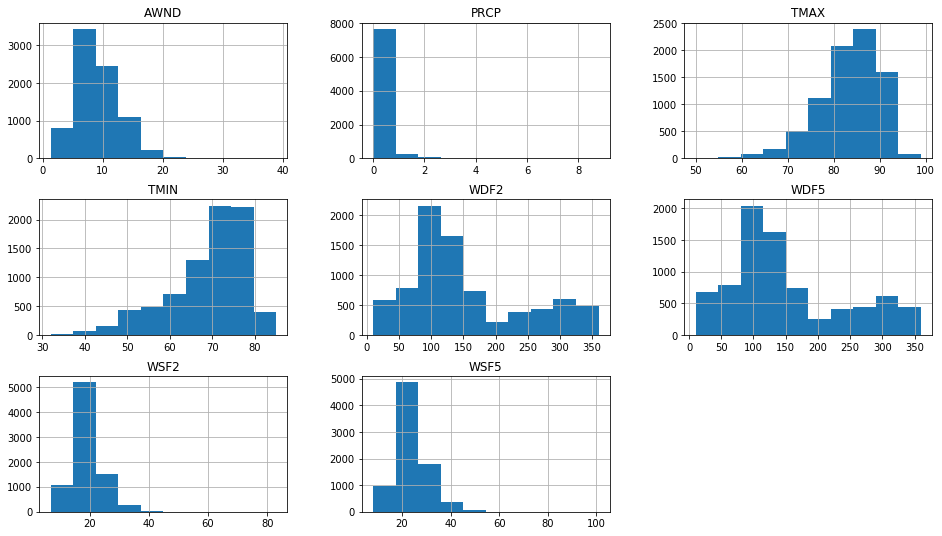

In [13]:
#Distrubtion of data using histograms. Look for normal distribution.
df.hist()
plt.show()

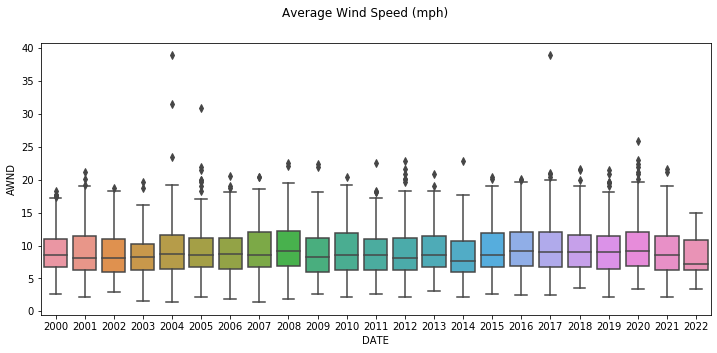

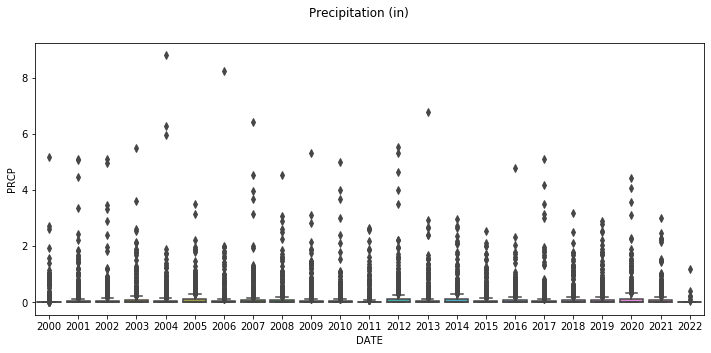

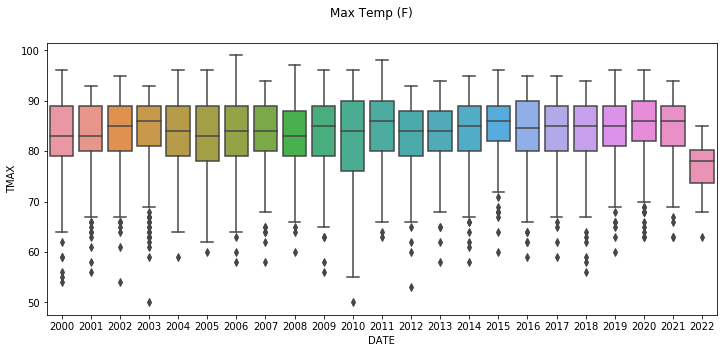

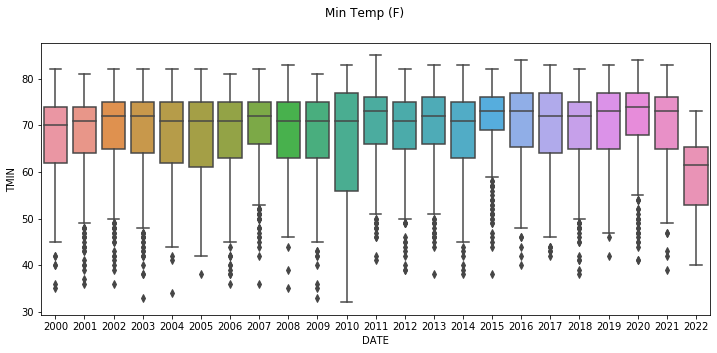

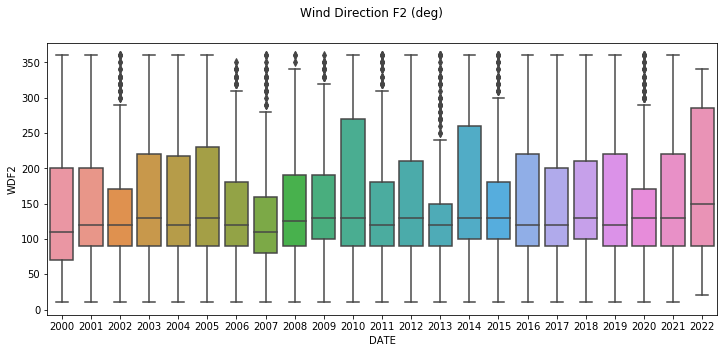

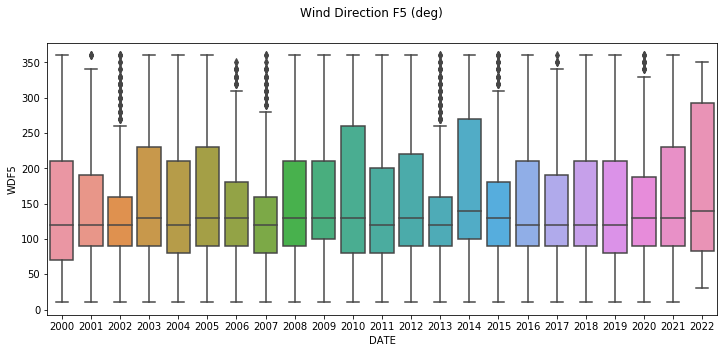

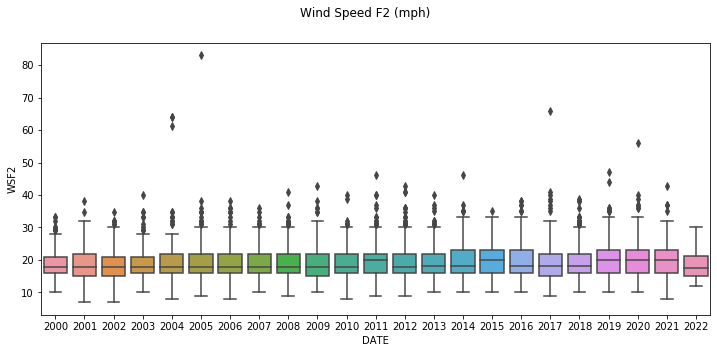

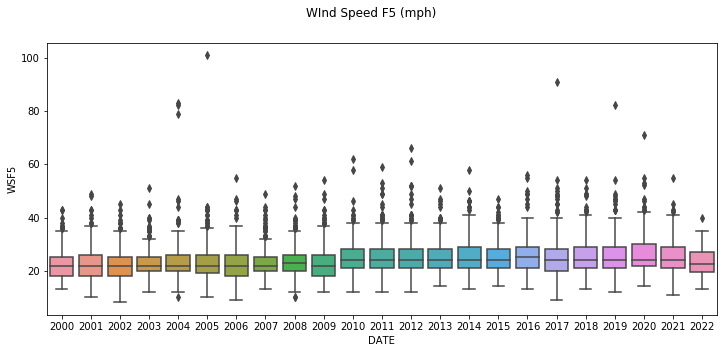

In [14]:
#Plot annual boxplot for each measurement. With this it is easier to see annual changes through the measurement history.
#It seems 2022 measurements are might have issues. 
columnNames = list(df.iloc[:,2:])
for x in (columnNames):
    fig, ax = plt.subplots(figsize=(12,5))
    fig.suptitle(metadict[x])
    sns.boxplot(df.index.year, df[x], ax=ax)
    plt.show()

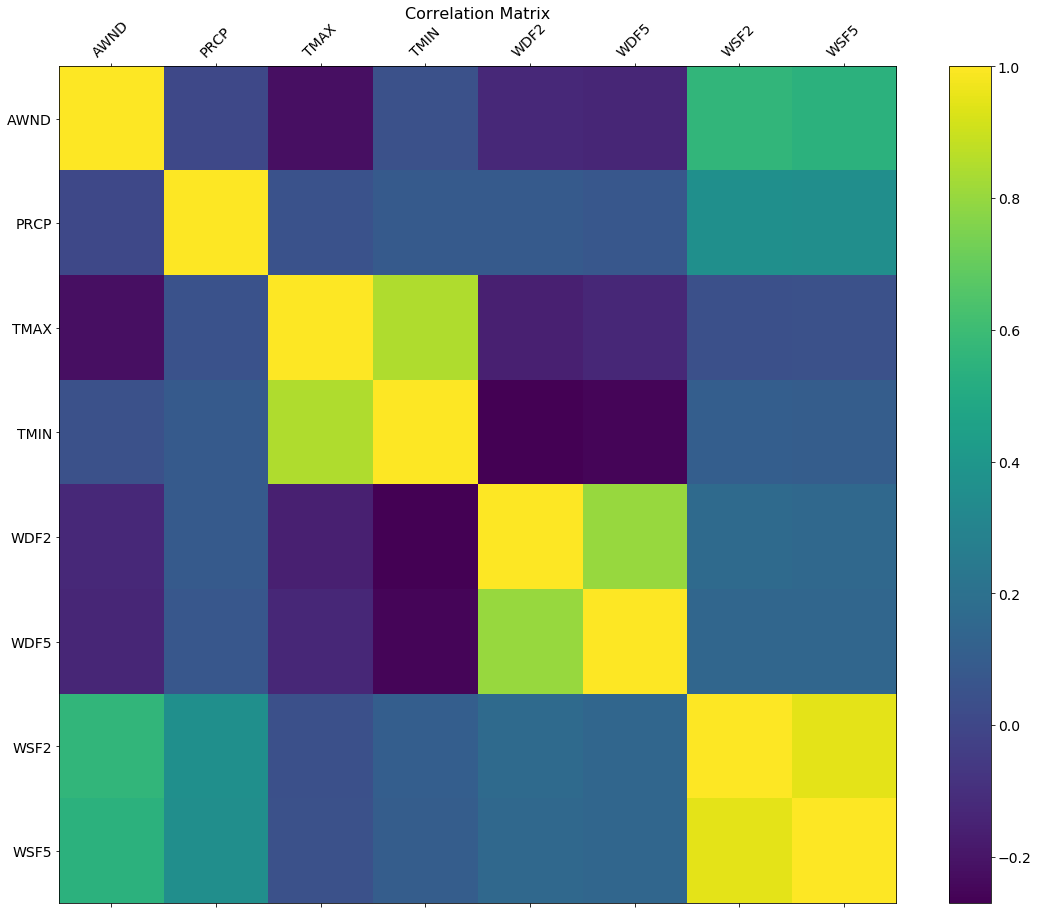

In [15]:
#Create correlation plot
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Concepts and terms related to time series.
1 Dependence- It refers to the association of two observations of the same variable at prior time periods.
2 Stationarity- It shows the mean value of the series that remains constant over the time period. If past effects accumulate and the values increase towards infinity then stationarity is not met.
3 Differencing- Differencing is used to make the series stationary and to control the auto-correlations. There may be some cases in time series analyses where we do not require differencing and over-differenced series can produce wrong estimates.
4 Specification - It may involve the testing of the linear or non-linear relationships of dependent variables by using time series models such as ARIMA models.
5 Exponential Smoothing - Exponential smoothing in time series analysis predicts the one next period value based on the past and current value. It involves averaging of data such that the non-systematic components of each individual case or observation cancel out each other. The exponential smoothing method is used to predict the short term prediction.
6 Curve fitting - Curve fitting regression in time series analysis is used when data is in a non-linear relationship.
7 ARIMA - ARIMA stands for Auto Regressive Integrated Moving Average.

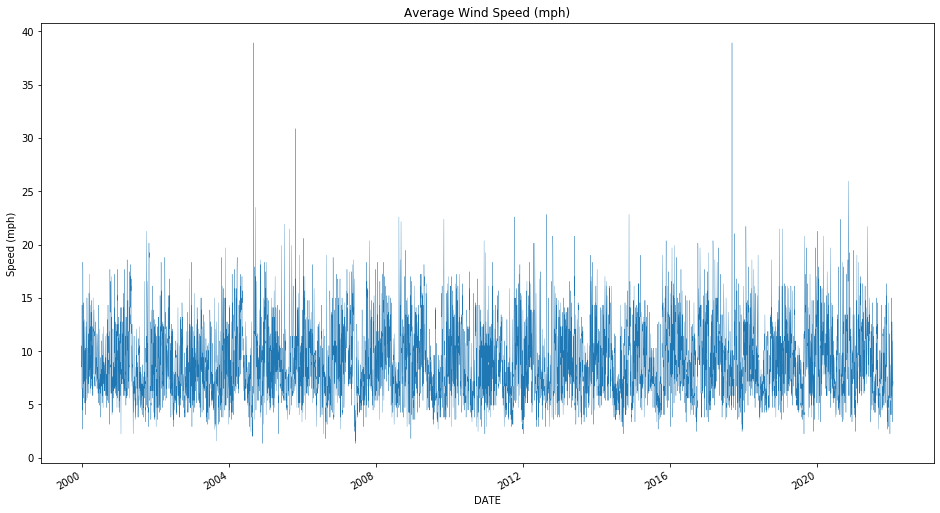

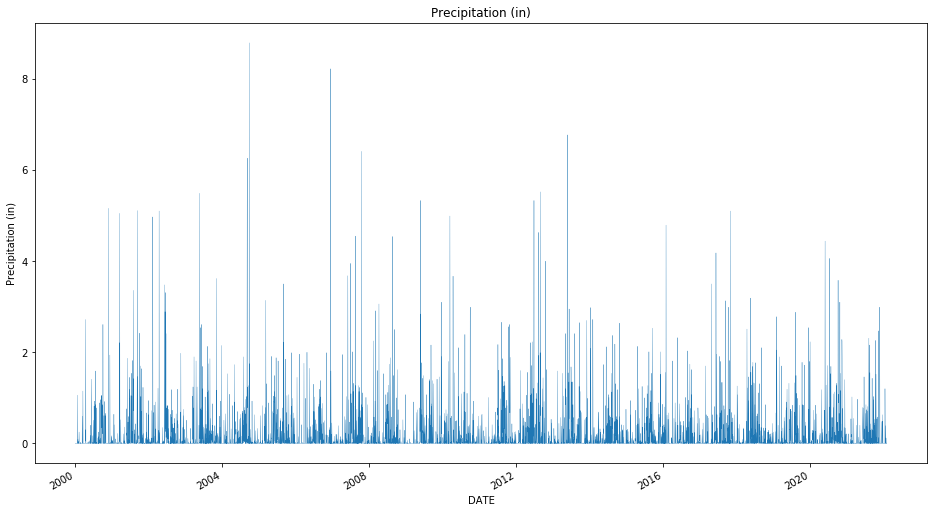

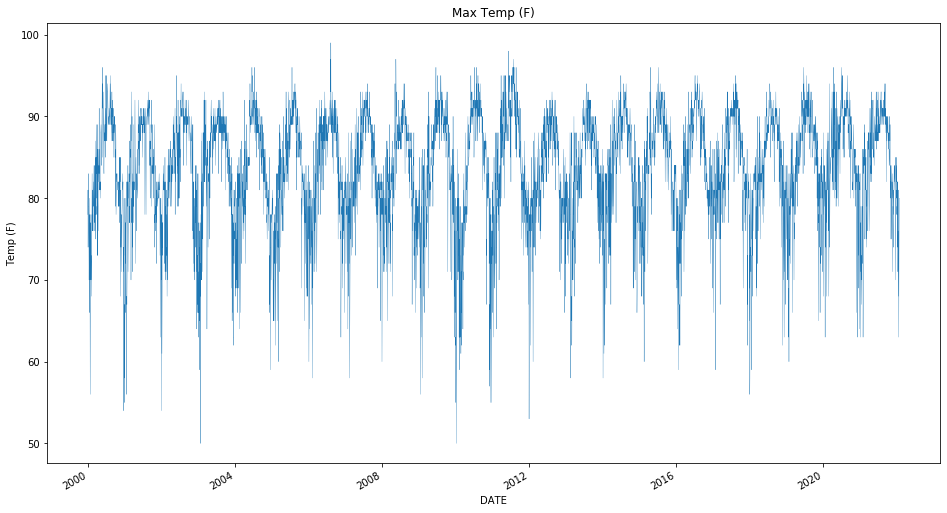

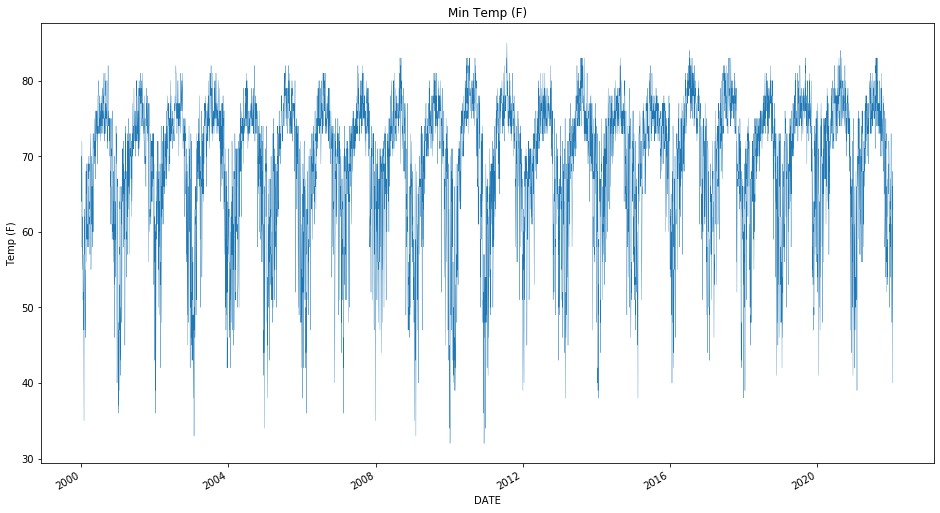

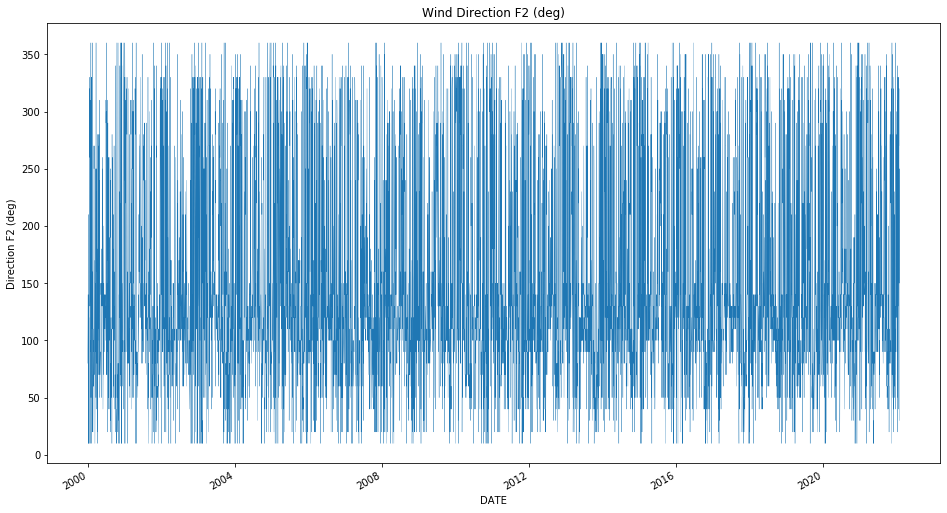

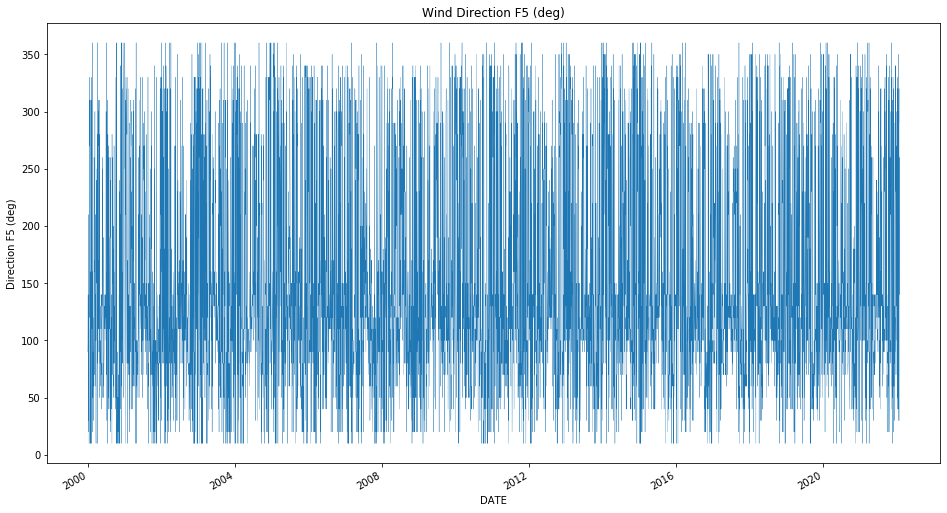

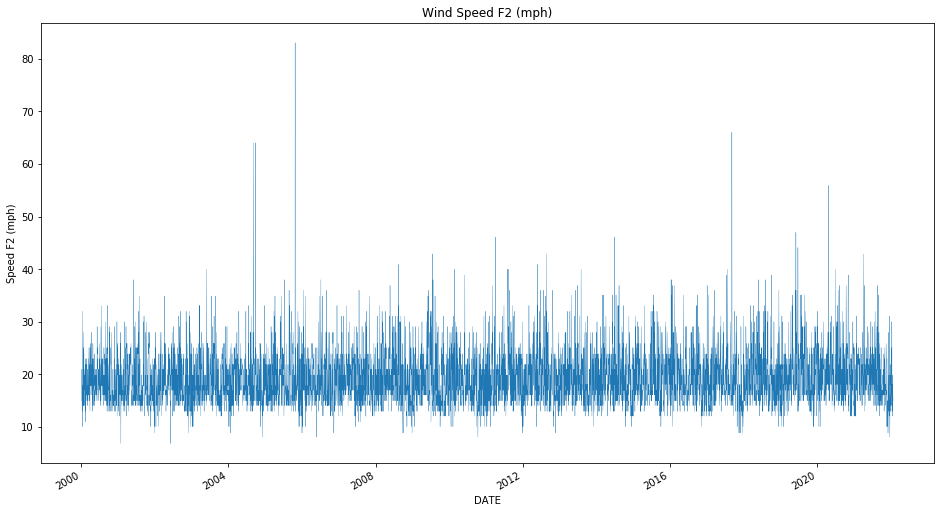

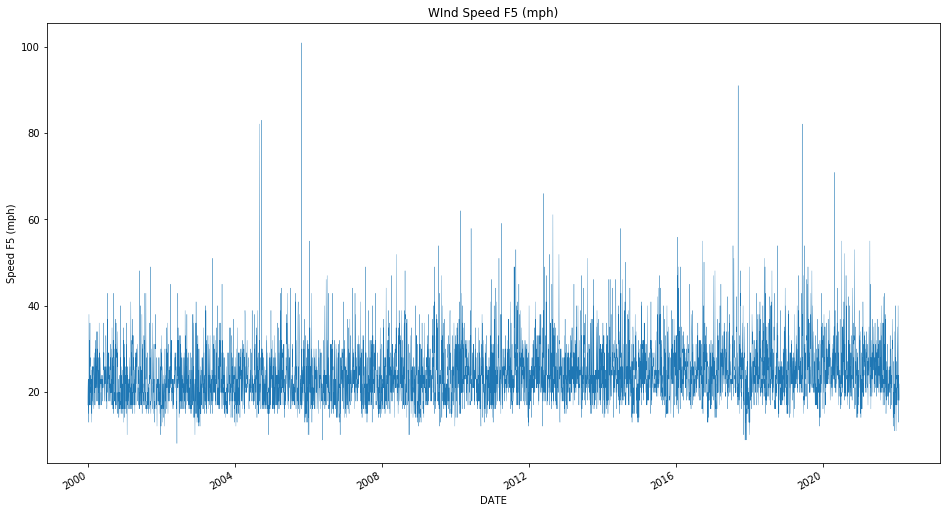

In [16]:
#Basic times series plots
for x in (columnNames):
    df[x].plot(linewidth=0.3)
    plt.title(metadict[x])
    plt.ylabel(metadictunits[x])
    plt.show()

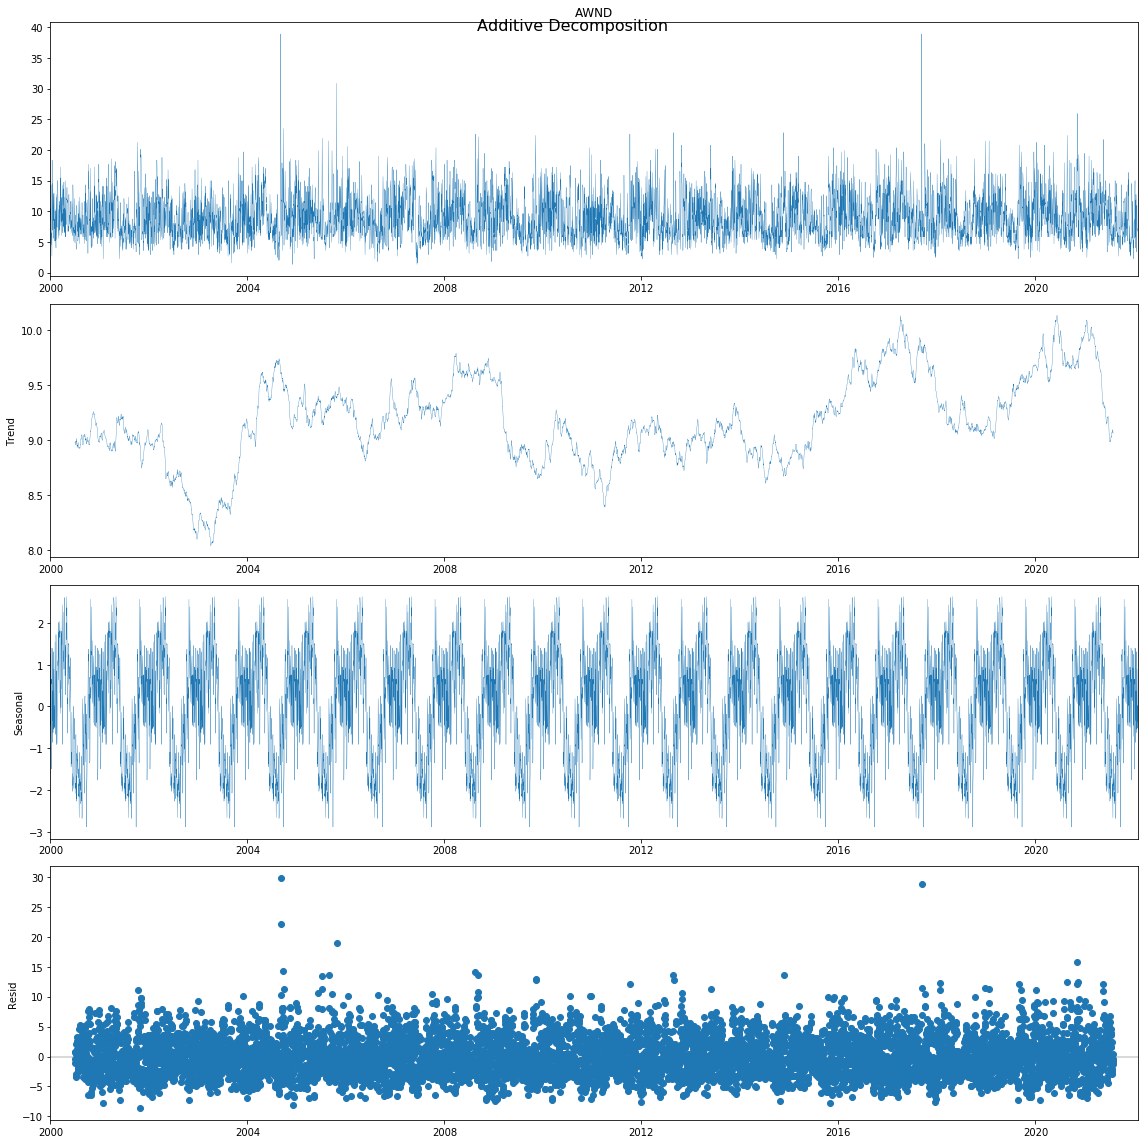

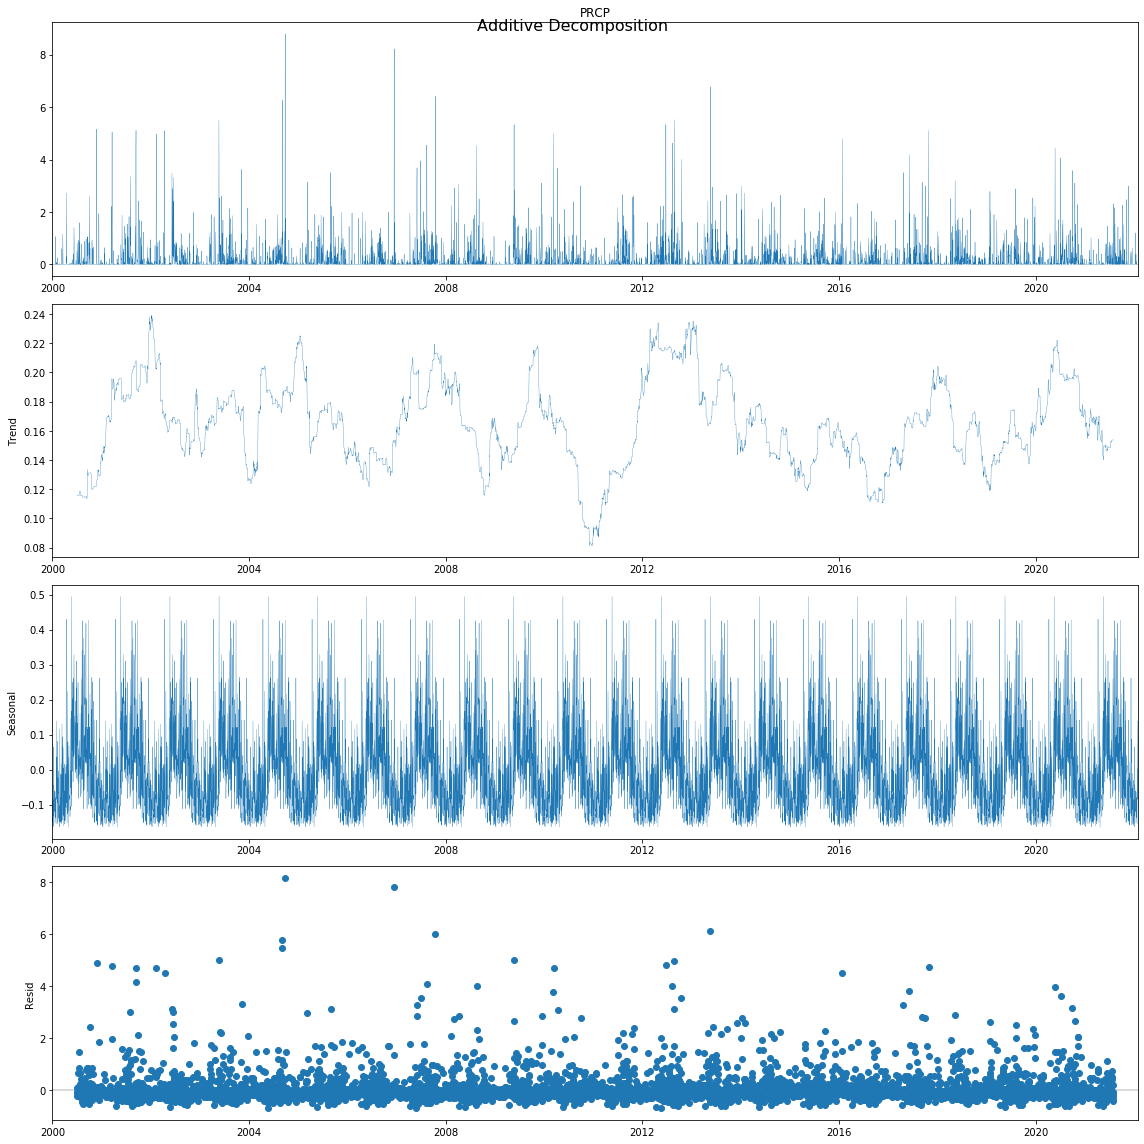

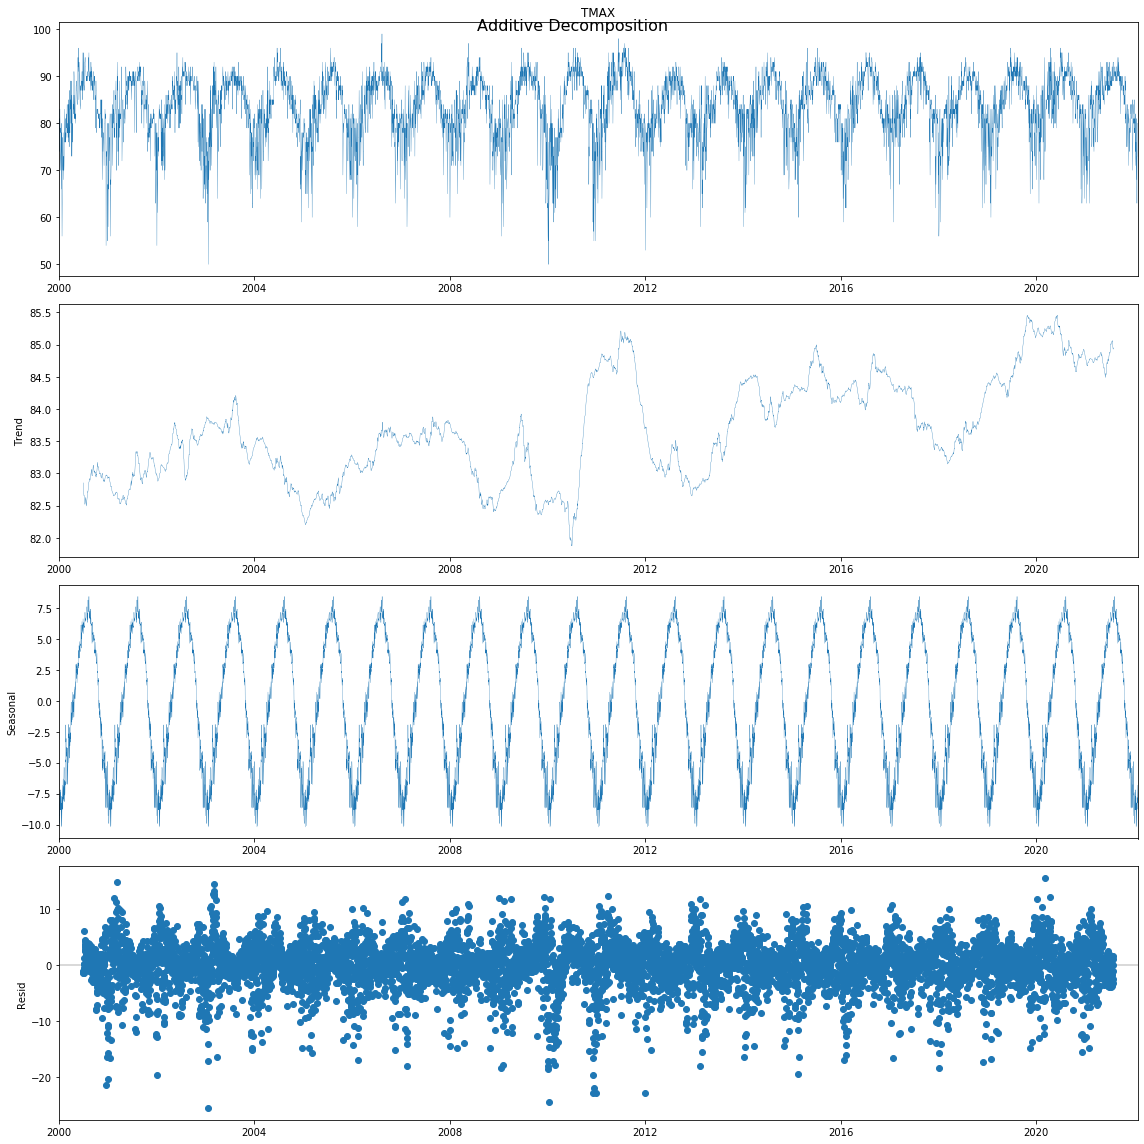

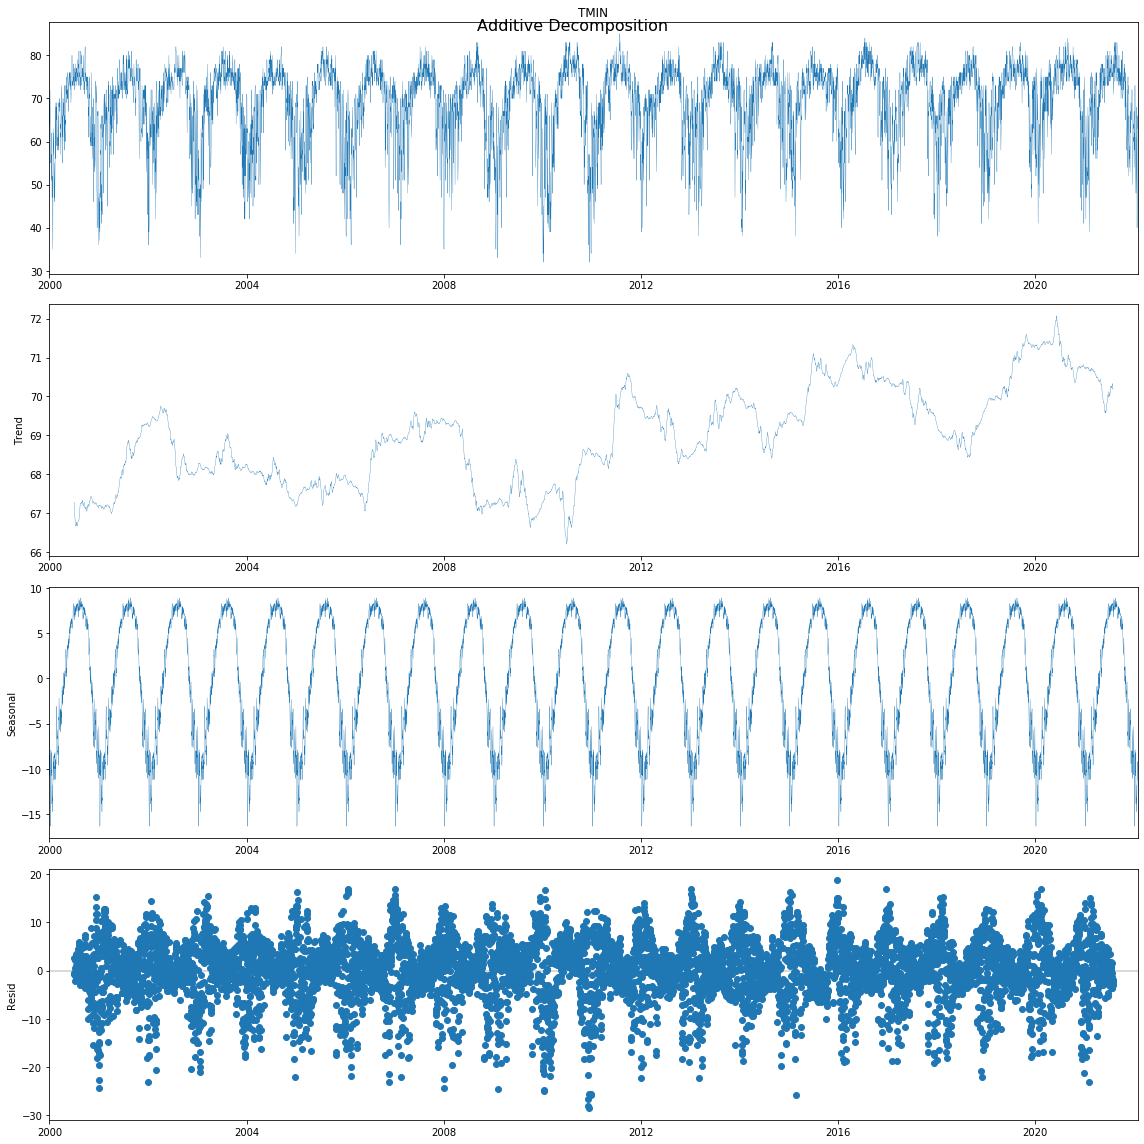

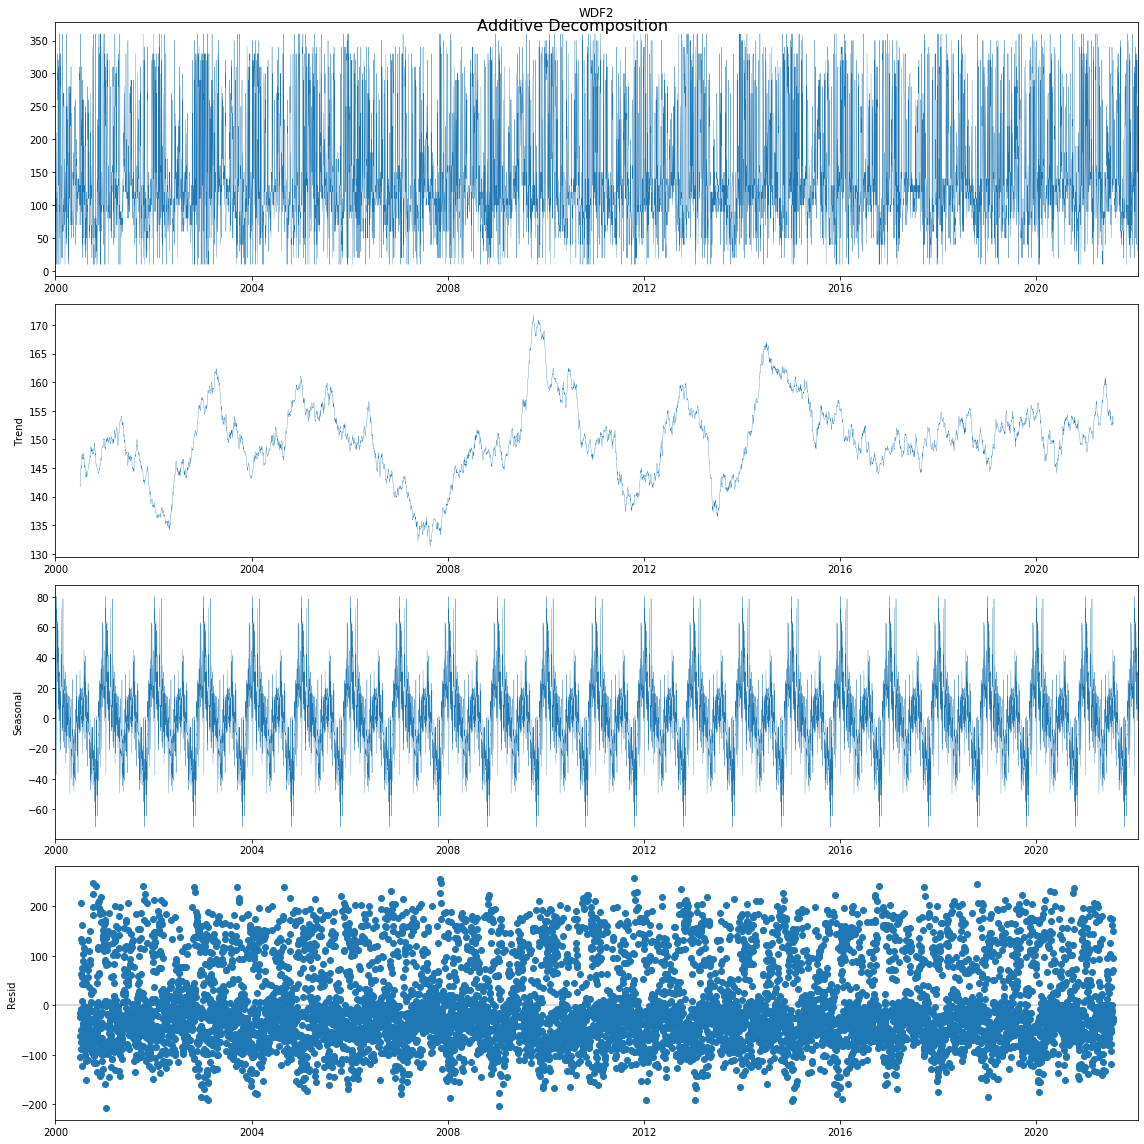

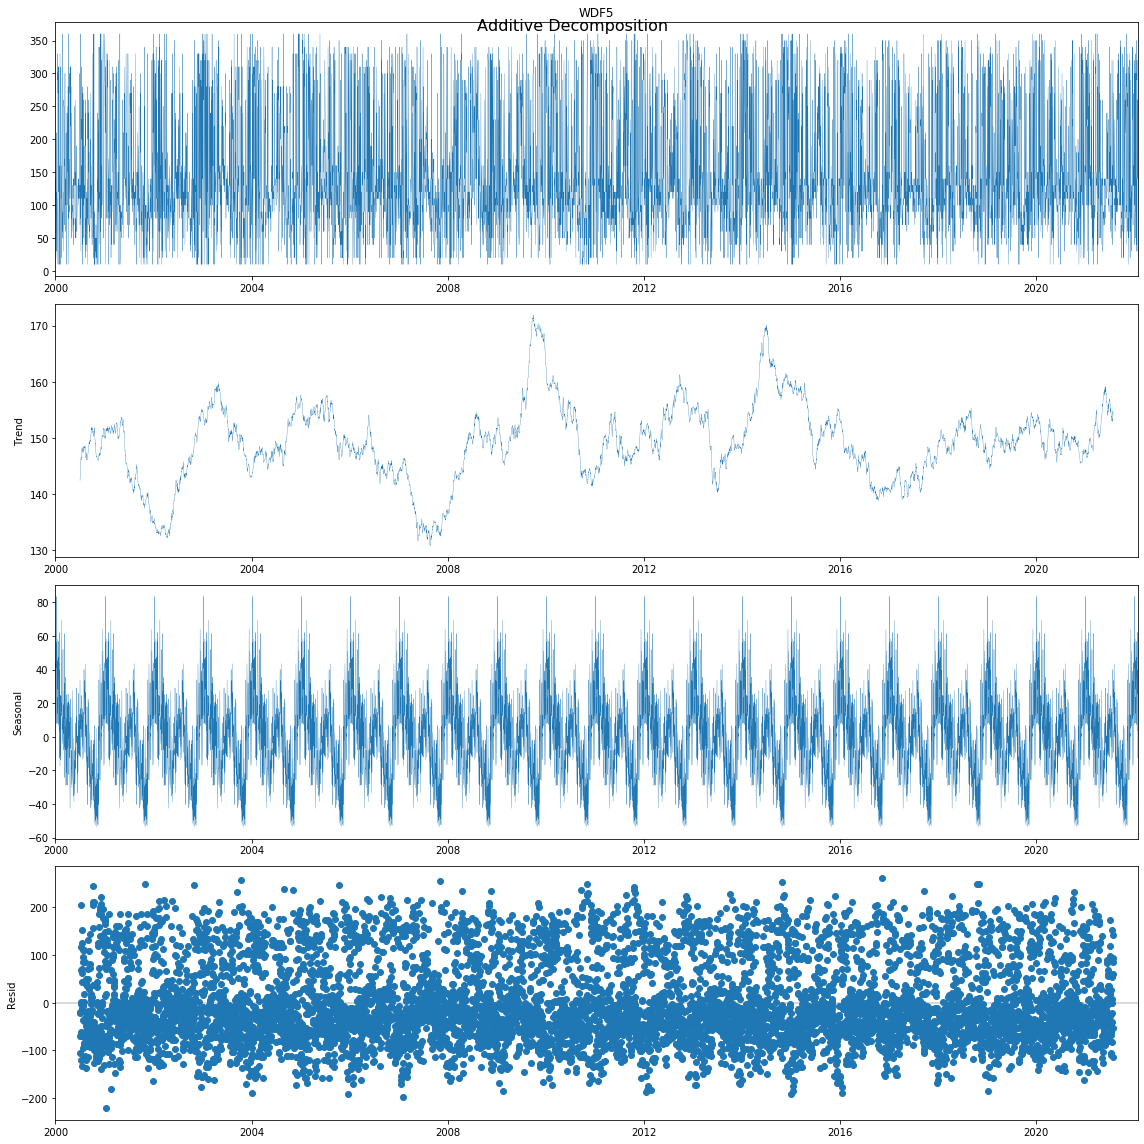

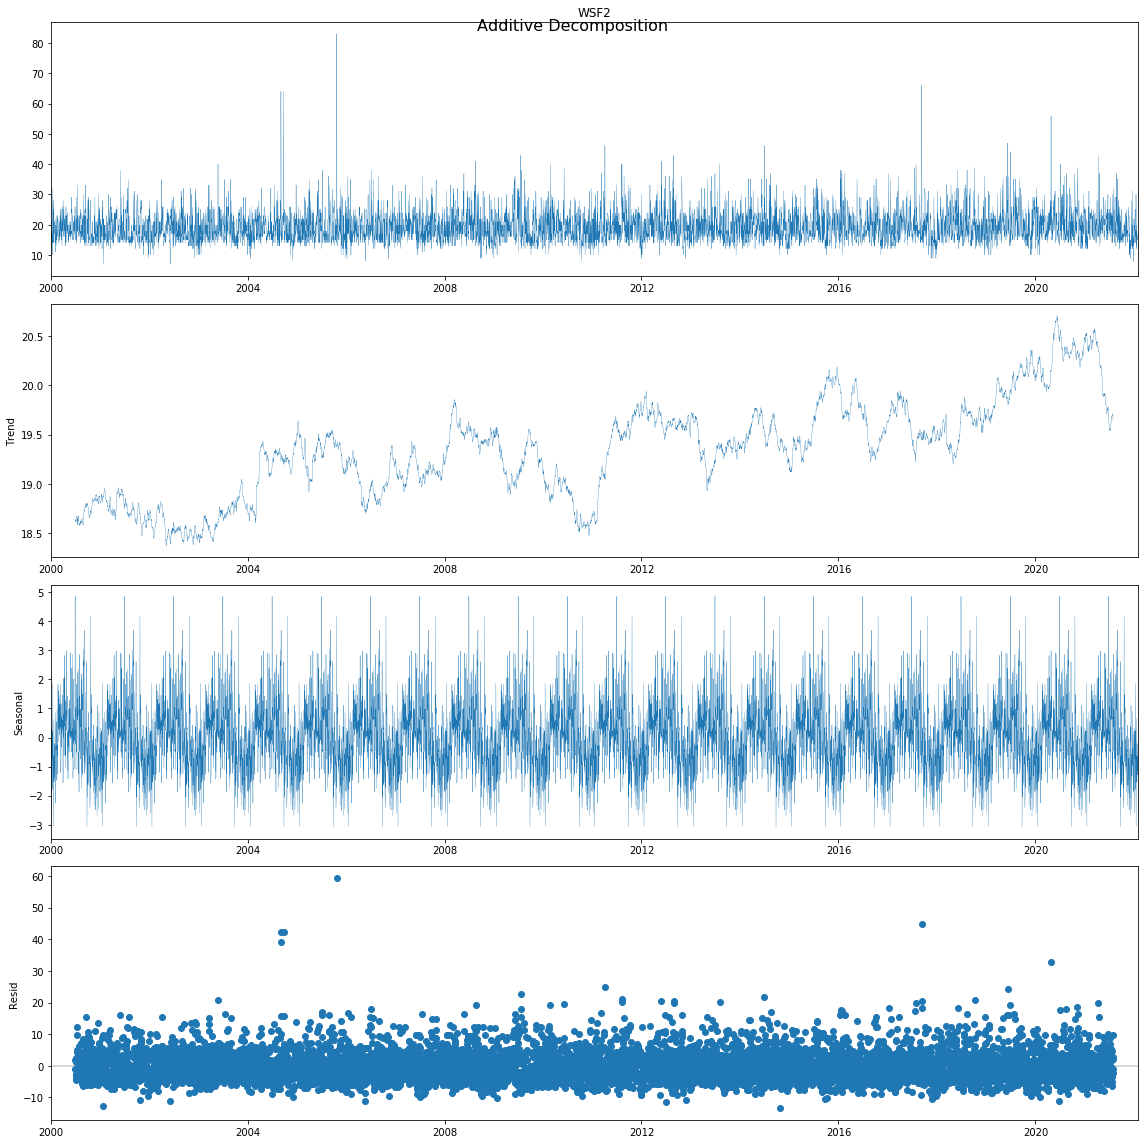

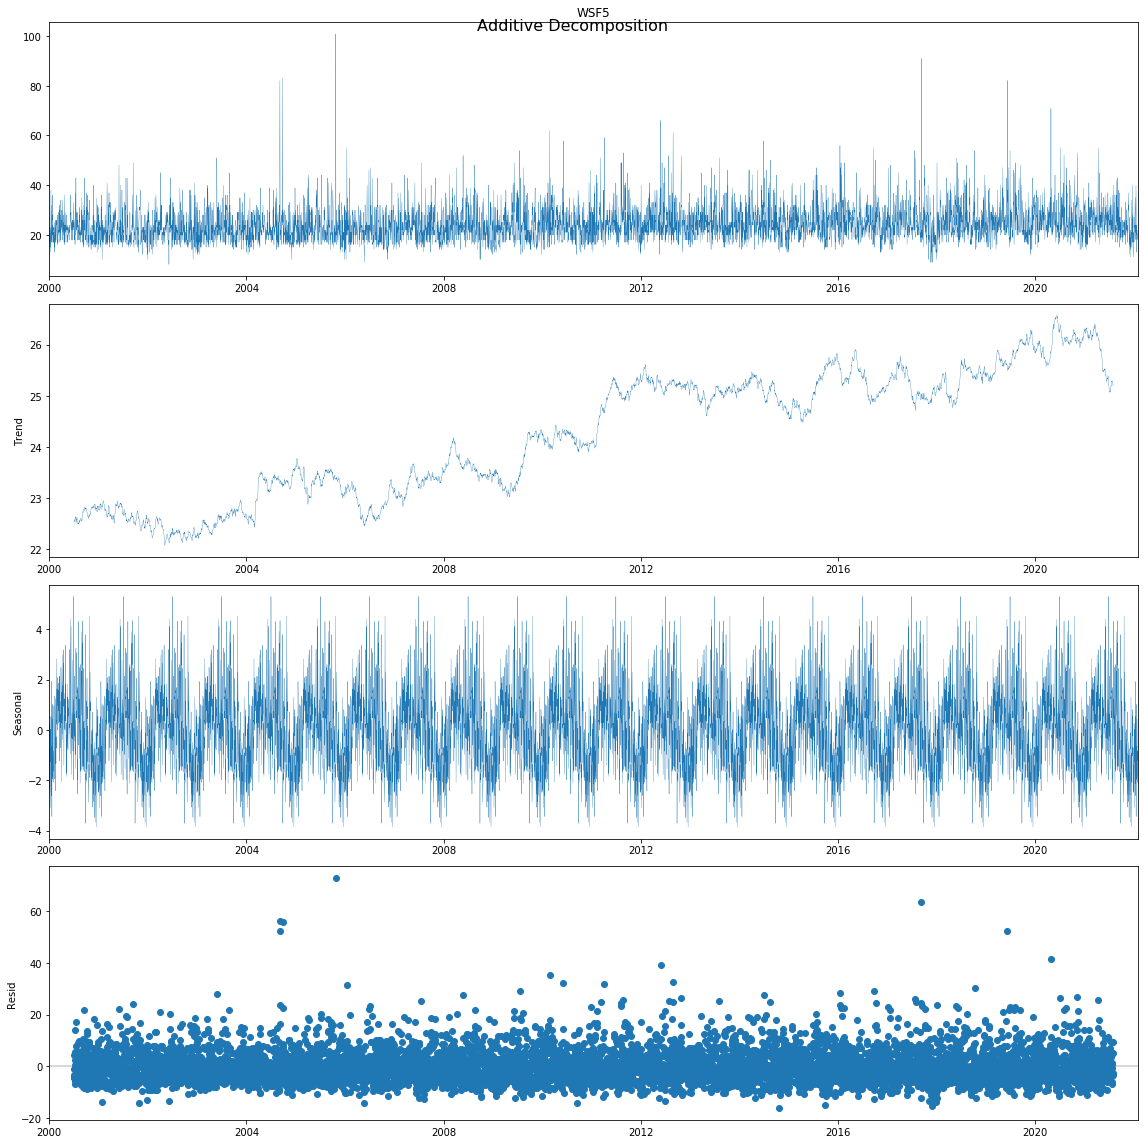

In [17]:
#Decompose time series as an additive multiplicative combination of the base level
#Look for trending and seasonality
rcParams['figure.figsize'] = 16, 16
rcParams['lines.linewidth'] = 0.3
#average 365 days of samples for trending
for x in (columnNames):
    additive_decomposition = seasonal_decompose(df[x], model='additive', period=365)
    additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
    plt.show()

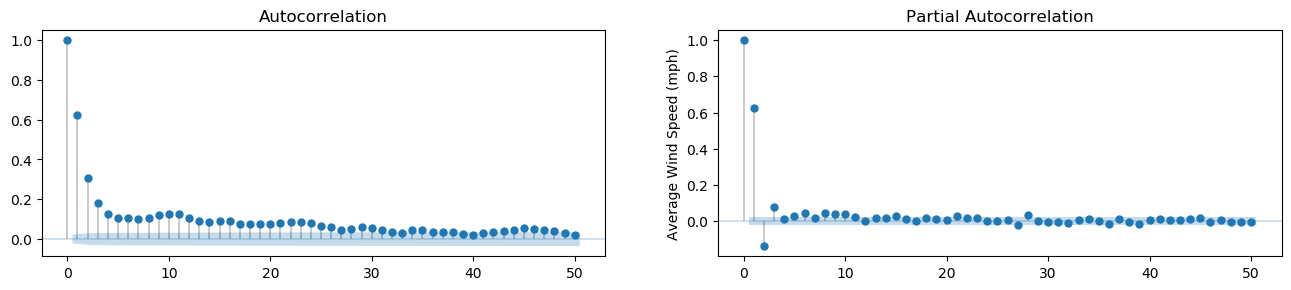

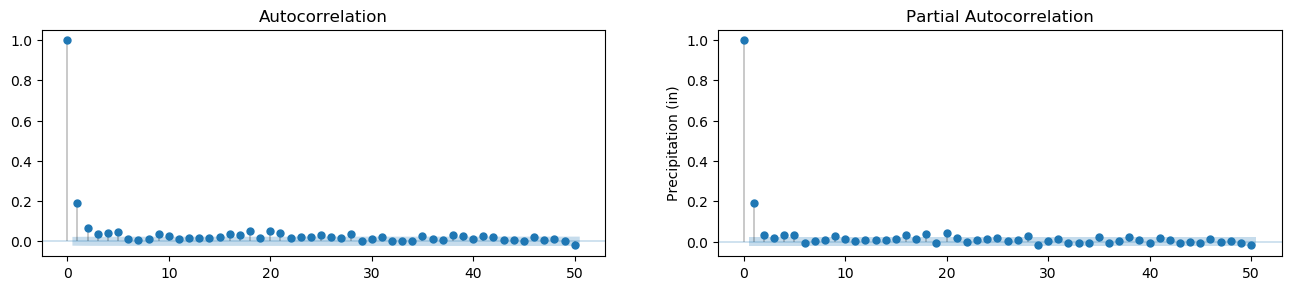

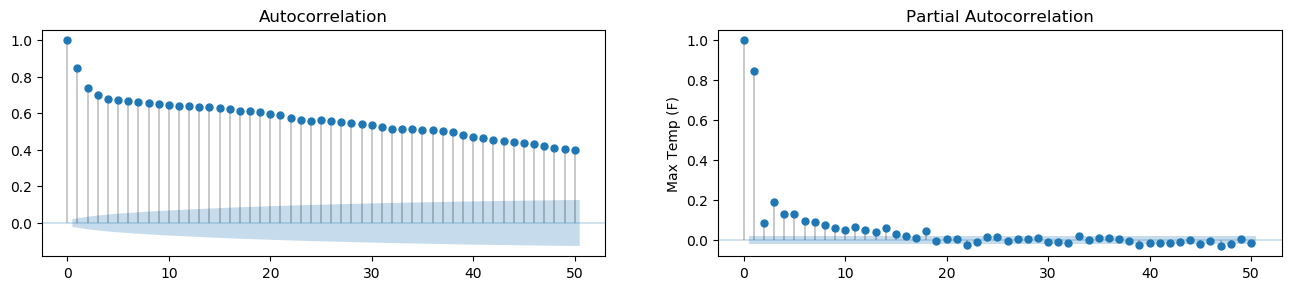

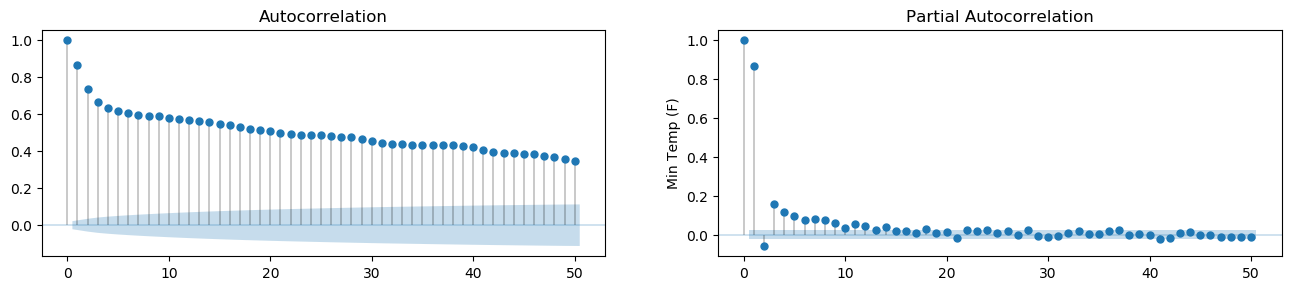

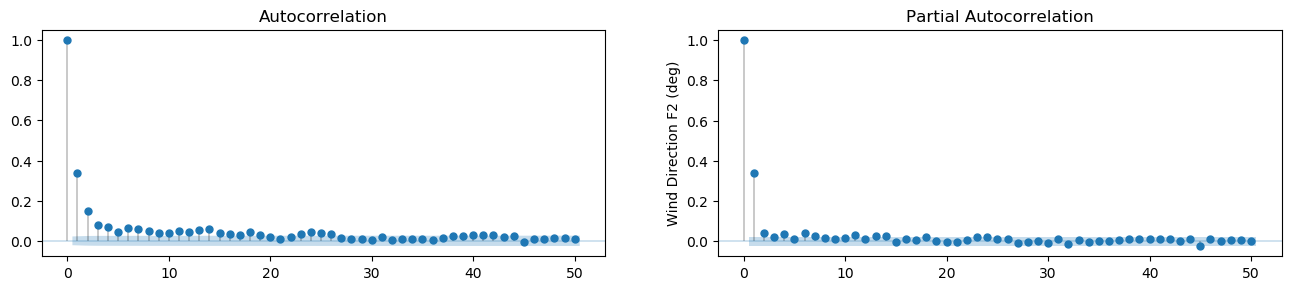

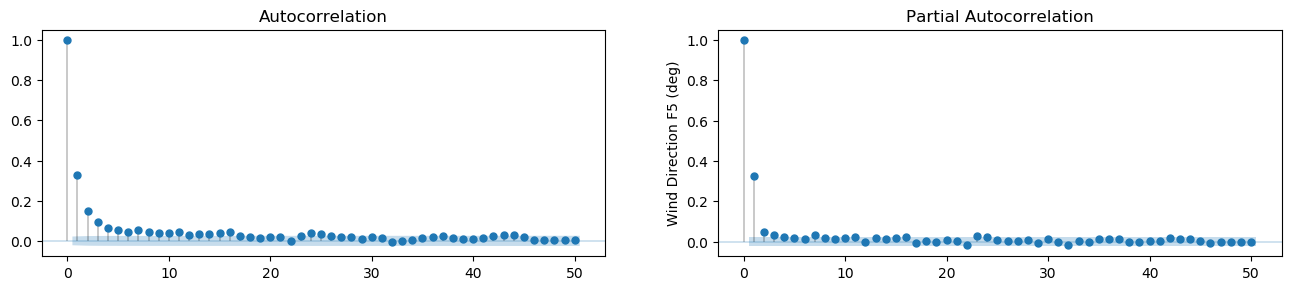

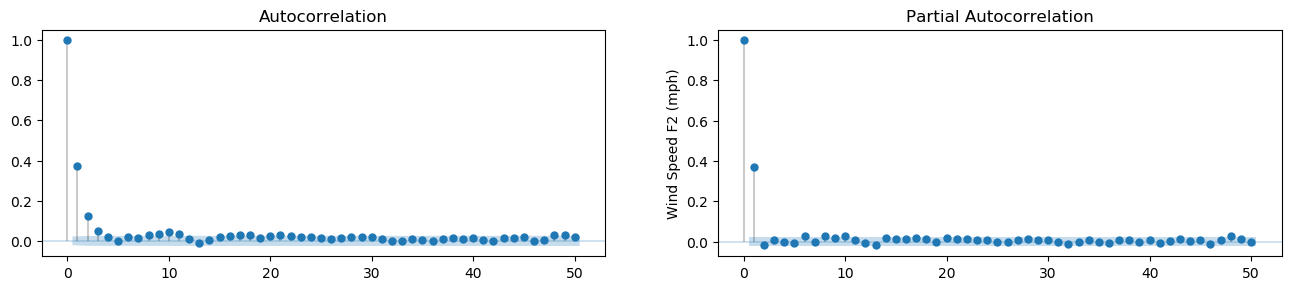

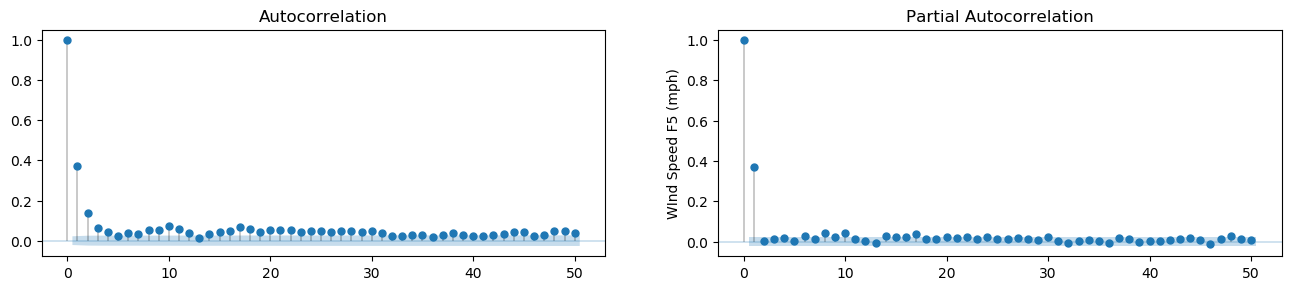

In [18]:
#Checking for any correlation. Autocorrelation, the previous values of the series (lags) may be helpful 
#in predicting the current value
for x in (columnNames):
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    plt.ylabel(metadict[x])
    plot_acf(df[x].tolist(), lags=50, ax=axes[0])
    plot_pacf(df[x].tolist(), lags=50, ax=axes[1])

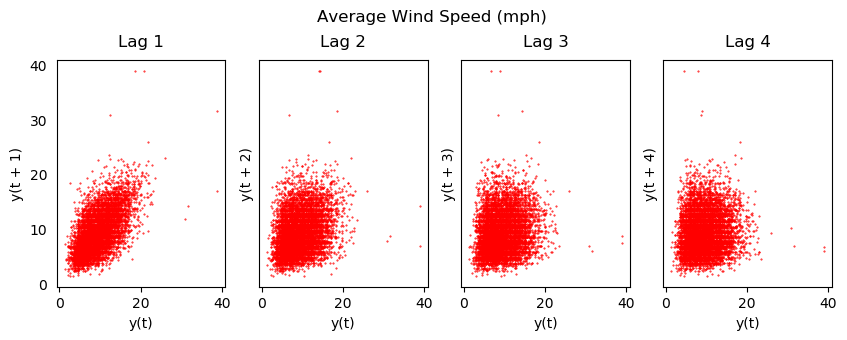

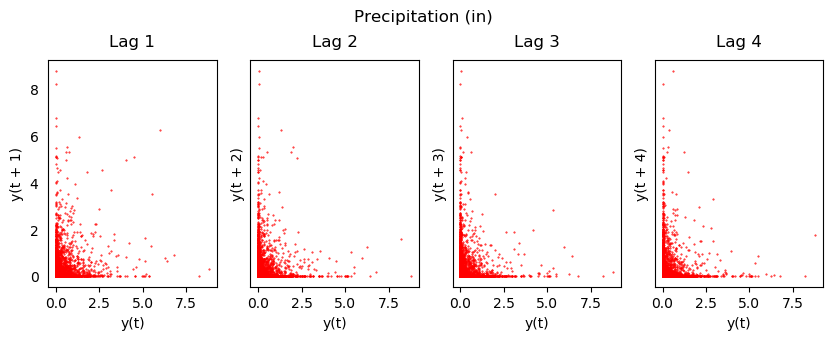

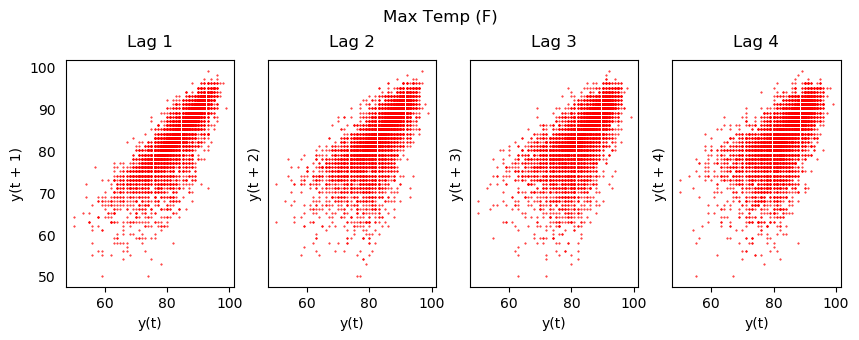

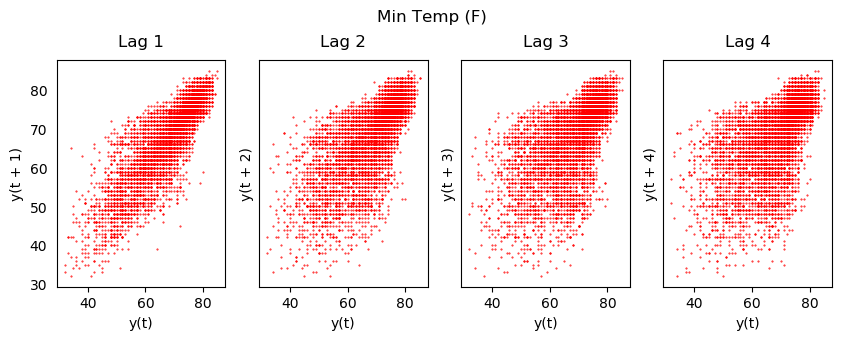

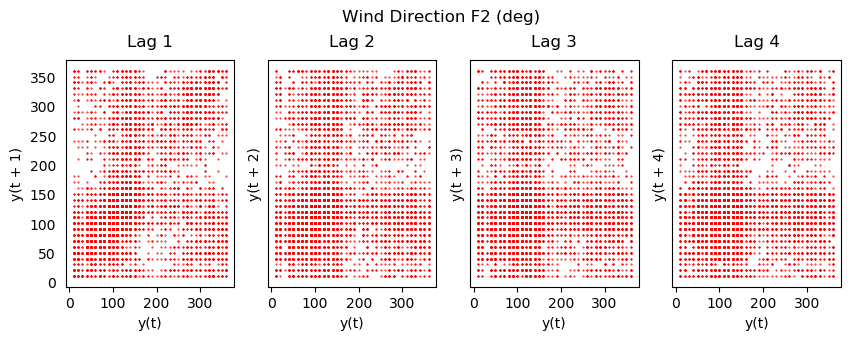

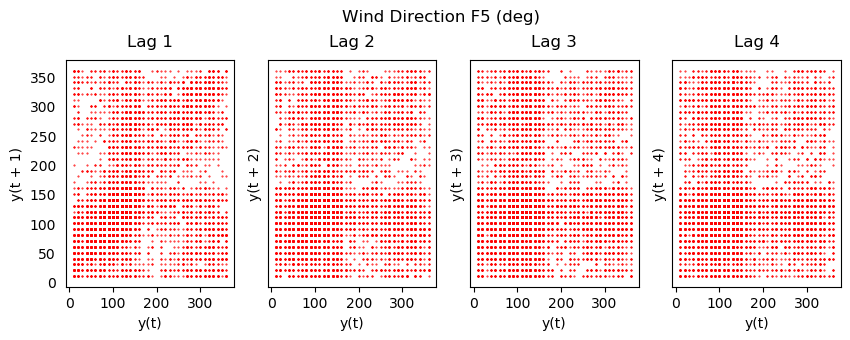

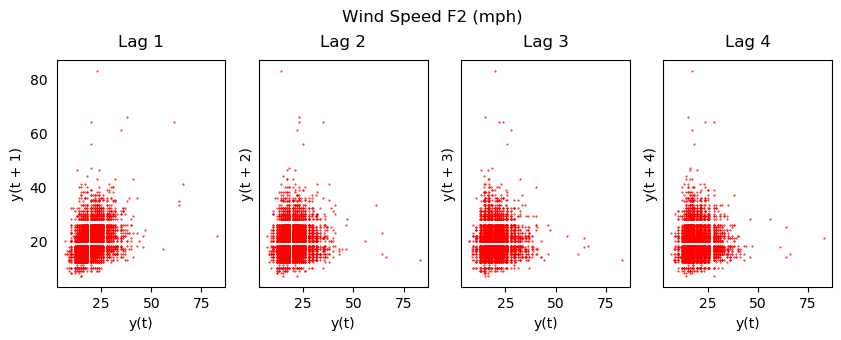

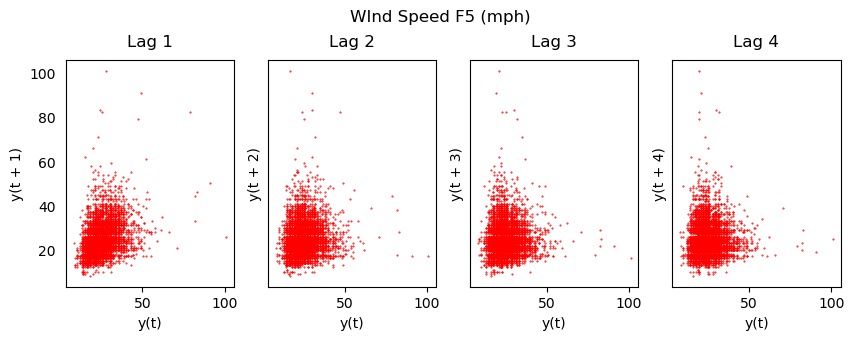

In [19]:
#Lag plots of each measument. Any pattern on the lag plots indicates autocorrelation. 
#Four next samples included on this analysis.
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})


for x in (columnNames):
    fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()[:4]):
        lag_plot(df[x], lag=i+1, ax=ax, c='red', s=0.2)
        ax.set_title('Lag ' + str(i+1))

    fig.suptitle((metadict[x]), y=1.05)    
    plt.show()

In [20]:
#Resample daily data to weekly, use mean as a weekly value
tmax=pd.DataFrame(df['TMAX'])
tmax = tmax.resample('W').mean()
tmax

TMAX
DATE                 
2000-01-02  78.000000
2000-01-09  78.714286
2000-01-16  76.571429
2000-01-23  74.000000
2000-01-30  67.428571
...               ...
2022-01-02  82.428571
2022-01-09  79.285714
2022-01-16  76.428571
2022-01-23  72.714286
2022-01-30  76.600000

[1153 rows x 1 columns]

In [21]:
#Fucntion to test stationarity of the data
def ADF(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [22]:
#Call AD Fuller test function
ADF(tmax,'Time series data')

 > Is the Time series data stationary ?
Test statistic = -13.119
P-value = 0.000
Critical values :
	1%: -3.436155341313321 - The data is  stationary with 99% confidence
	5%: -2.8641034026875123 - The data is  stationary with 95% confidence
	10%: -2.568134825546958 - The data is  stationary with 90% confidence


In [23]:
#Split the train, test sets and the number of sampples for forecast
tmax_train = tmax[:'2019-05-30'] # dataset to train
tmax_test = tmax['2019-06-02':] # last X months for test  
predict_date = len(tmax) - len(tmax[:'2019-06-02']) # the number of data points for the test set

## Expotential Smoothing

C:\Users\marpulli\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Trend=add, Seasonal=add, RMSE=2.26


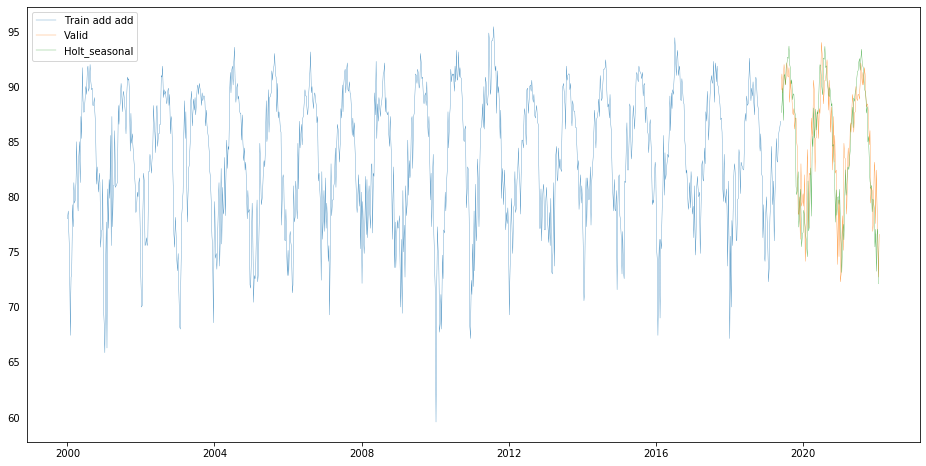

C:\Users\marpulli\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Trend=add, Seasonal=mul, RMSE=2.29


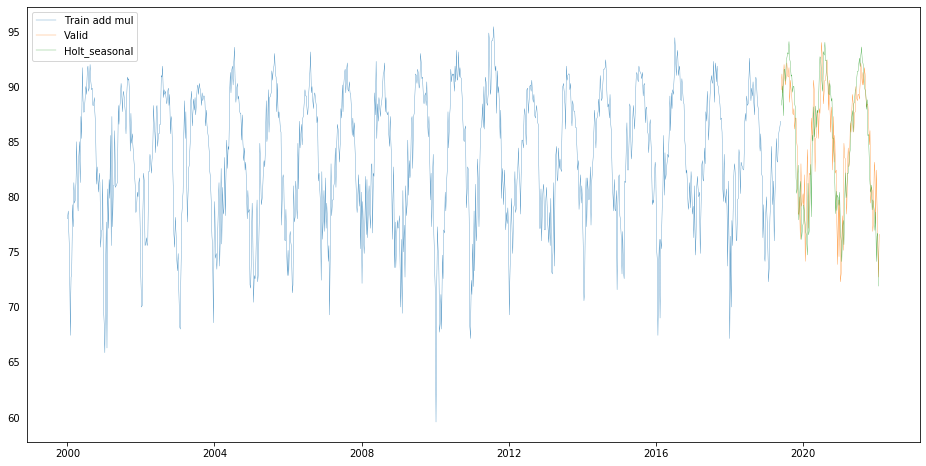

C:\Users\marpulli\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Trend=mul, Seasonal=add, RMSE=2.19


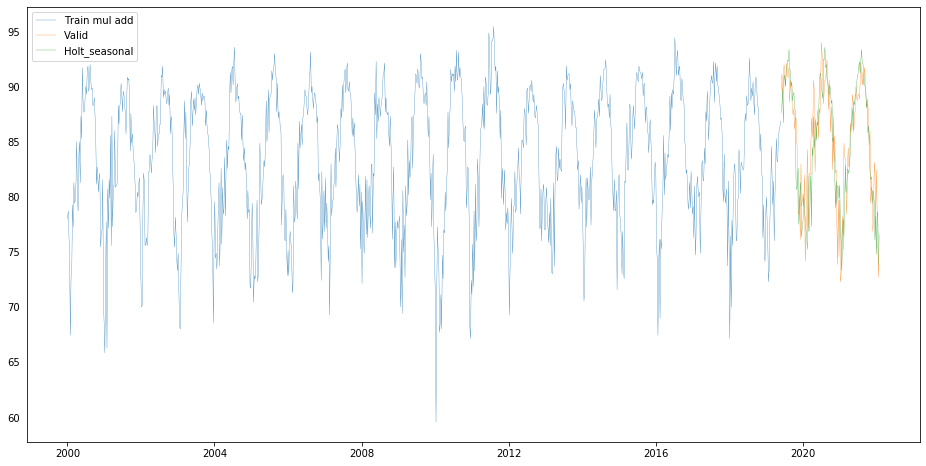

C:\Users\marpulli\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Trend=mul, Seasonal=mul, RMSE=2.23


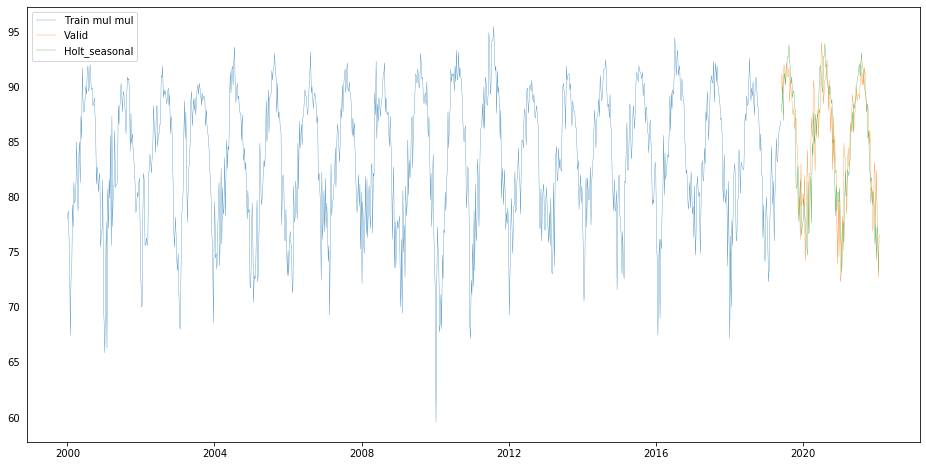

In [24]:
#Find best performing parameter set. Usd model is ExponentialSmoothing from statsmodels.org
warnings.simplefilter('ignore', ConvergenceWarning)

seasonal = ['add', 'mul']
trending = ['add', 'mul']

for y in seasonal:
    for x in trending:
        y_hat_avg = tmax_test.copy() 
        fit1 = ExponentialSmoothing(tmax_train, seasonal_periods = 365, 
                                    trend=x, seasonal=y, freq='W').fit()
        
        y_hat_avg['Holt_seasonal'] = fit1.forecast(predict_date).rename('Additive')
        mse = round(np.sqrt((y_hat_avg['TMAX'] - y_hat_avg['Holt_seasonal']) ** 2).mean(),2)
        print('Trend={}, Seasonal={}, RMSE={}'.format(y,x,mse))
        plt.figure(figsize=(16,8),linewidth=0.6)
        plt.plot(tmax_train['TMAX'], label='Train '+y+' '+x)
        plt.plot(tmax_test['TMAX'], label='Valid') 
        plt.plot(y_hat_avg['Holt_seasonal'], label='Holt_seasonal') 
        plt.legend(loc='best') 
        plt.show()

C:\Users\marpulli\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


RMSE=2.19


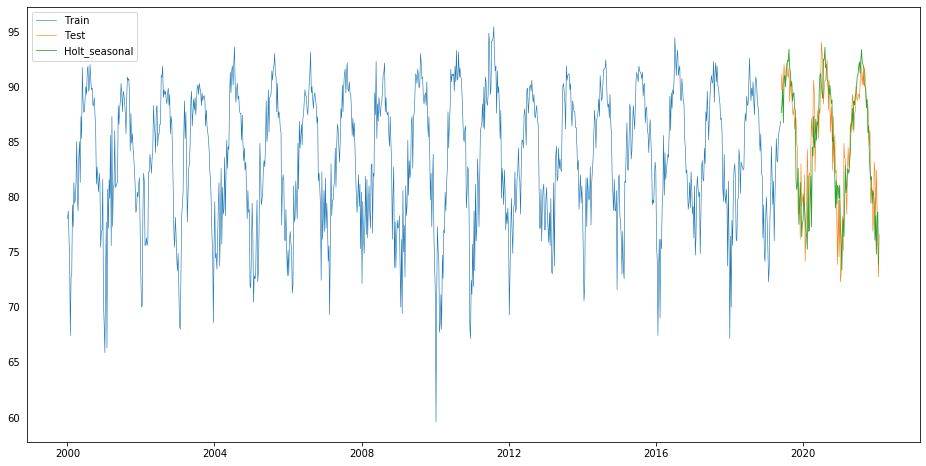

In [33]:
#Fit the model using the best model parameters
test_fore = tmax_test.copy() 
fittest = ExponentialSmoothing(tmax_train, seasonal_periods = 365, trend='add', seasonal='mul', freq='W').fit()
test_fore['Holt_seasonal'] = fittest.forecast(predict_date).rename('Additive')
mse = round(np.sqrt((test_fore['TMAX'] - test_fore['Holt_seasonal']) ** 2).mean(),2)
print('RMSE={}'.format(mse))
plt.figure(figsize=(16,8),)
plt.plot(tmax_train['TMAX'], label='Train', linewidth=0.6)
plt.plot(test_fore['TMAX'], label='Test', linewidth=0.6) 
plt.plot(test_fore['Holt_seasonal'], label='Holt_seasonal', linewidth=0.8) 
plt.legend(loc='best') 
plt.show()

C:\Users\marpulli\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


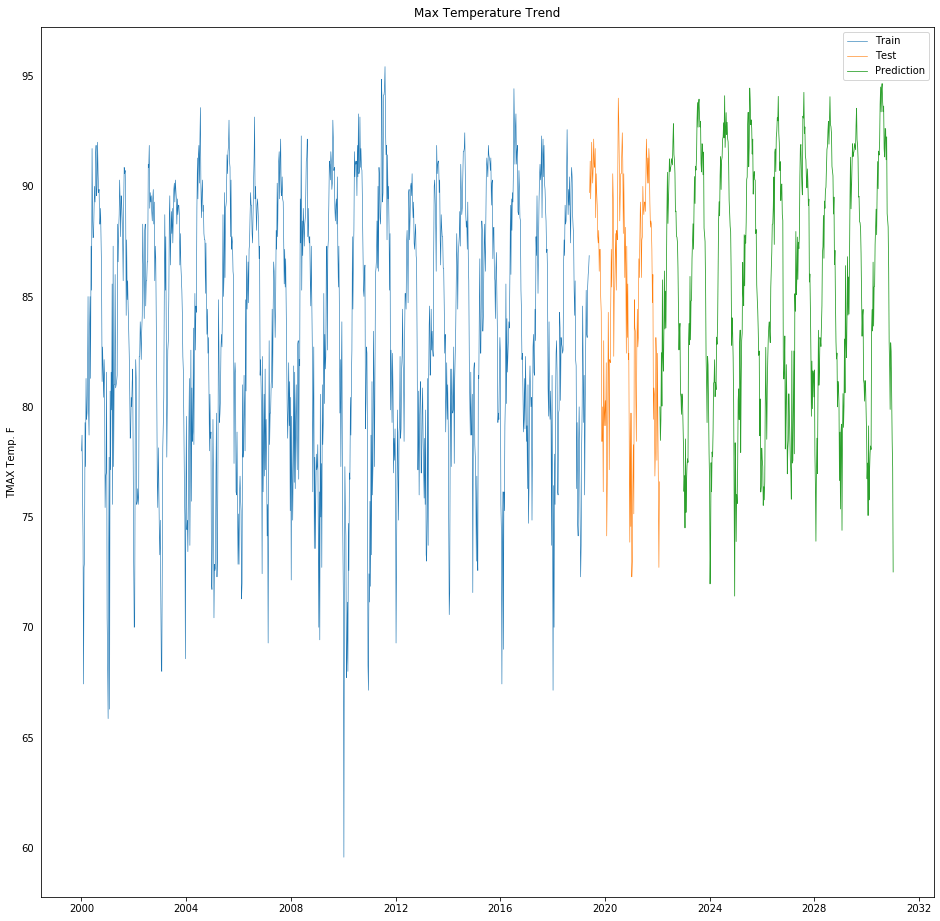

In [26]:
#Complete the prediction for future years to come
y_pred = fittest.predict('2022-02-01','2030-12-31')
plt.plot(tmax_train['TMAX'], label='Train', linewidth=0.6)
plt.plot(test_fore['TMAX'], label='Test', linewidth=0.6)
plt.plot(y_pred, label='Prediction', linewidth=0.8) 
plt.title('Max Temperature Trend')
plt.ylabel('TMAX Temp. F')
plt.legend(loc='best') 
plt.show()